In [1]:
import warnings
warnings.filterwarnings("ignore")

# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
from pprint import pprint

from gensim import corpora, models
from gensim.models import Phrases
from gensim.models import CoherenceModel
from gensim.models.nmf import Nmf
from gensim.models.lsimodel import LsiModel
from gensim.models.ldamodel import LdaModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
%matplotlib inline

/Users/brianroepke/miniforge3/envs/NLP/lib/python3.9/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [3]:
df = pd.read_pickle('tesla_clean.pkl')
df.reset_index(inplace=True)

In [4]:
documents = df['Discussion_Clean'].to_list()

In [5]:
df['Discussion_Clean'][5]

'hear incentive tax credit long offer first car order true'

In [6]:
stoplist = ['the', 'a', 'an', 'of', 'and', 'or', 'in', 'for', 'to', 'at', 'by', 'from', 'with', 'on', 'as', 'but', 'is', 'are', 'was', 'were', 'be', 'been', 'am', 'i', 'me', 'my', 'we', 'our', 'you', 'your', 'yours', 'he', 'she', 'it', 'they', 'them', 'their', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'can', 'will', 'would', 'should', 'could', 'may', 'might', 'must', 'ought', 'i', 'you', 'he', 'she', 'it', 'thank', 'lol', 'yes', 'nope', 'get', 'go', 'one', 'see', 'haha', 'nice', 'flag', 'spam', 'shit', 'here', 'look', 'use', 'good', 'say', 'think', 'know', 'nah', 'ah', 'time', 'fish', 'troll', 'nazi', 'ha', 'bye', 'ok', 'okay', 'fucking', 'andy', 'idiot', 'httpsteslatapcomarticlesownersmanualcompanionsearch', 'fishy', 'fishev', 'evil', 'tanya', 'lilbean', 'eaglespdx', 'lie', 'maxxer', 's', 'nt', 'not', 'do', 'like', 'well', 've', 'try']

In [7]:
# remove common words and tokenize
texts = [
    [word for word in document.lower().split() if word not in stoplist]
    for document in documents
]

In [8]:
# remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

In [9]:
texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts
]

In [10]:
# # Add bigrams and trigrams to docs (only ones that appear 20 times or more).
# bigram = Phrases(texts, min_count=20)
# for idx in range(len(texts)):
#     for token in bigram[texts[idx]]:
#         if '_' in token:
#             # Token is a bigram, add to document.
#             texts[idx].append(token)

In [11]:
# Create the dictionary
dictionary = corpora.Dictionary(texts)

In [12]:
# Filter out words that occur less than X documents, or more than X% of the documents.
dictionary.filter_extremes(no_below=50, no_above=0.5)

In [13]:
# Create the corpus.  This is a Term Frequency or Bag of Words representation.
corpus = [dictionary.doc2bow(text) for text in texts]

In [14]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 2461
Number of documents: 54335


In [15]:
# You can also use TF-IDF instead of BOW
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

## Compare Different Topic Modeling Algorithms

In [16]:
# Create an arbitrary number of topics to start
NUM_TOPICS = 10

In [17]:
def model_scoring (model, corpus, text, dictionary, perplex=False):

    # Compute Perplexity
    # a measure of how good the model is. lower the better.
    if perplex:
        print('Perplexity: ', model.log_perplexity(corpus))  

    # Compute Coherence Score
    coherence_model = CoherenceModel(model=model, 
                                         texts=text, 
                                         dictionary=dictionary, 
                                         coherence='c_v')
    
    coherence_lda = coherence_model.get_coherence()
    print('Coherence Score: ', coherence_lda)

In [18]:
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=NUM_TOPICS, random_state=42)

model_scoring(lda_model, corpus, texts, dictionary, perplex=True)

Perplexity:  -7.0215461671994674
Coherence Score:  0.5463850924315429


## Compute the Best Number of Topics

In [19]:
NUM_TOPICS = 16
# Set training parameters.
chunksize = 2000
passes = 6
iterations = 100
eval_every = None  # Don't evaluate model perplexity, takes too much time.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

In [20]:
def compute_coherence_values(dictionary, corpus, texts, cohere, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, 
                         id2word=dictionary, 
                         num_topics=num_topics,
                         chunksize=chunksize,
                         alpha='auto',
                         eta='auto',
                         iterations=iterations,
                         passes=passes,
                         eval_every=eval_every,
                         random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=cohere)
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [21]:
limit=30
start=2
step=2

In [22]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=corpus, 
                                                        texts=texts, 
                                                        cohere='c_v', # 'u_mass', 'c_v', 'c_uci', 'c_npmi'
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

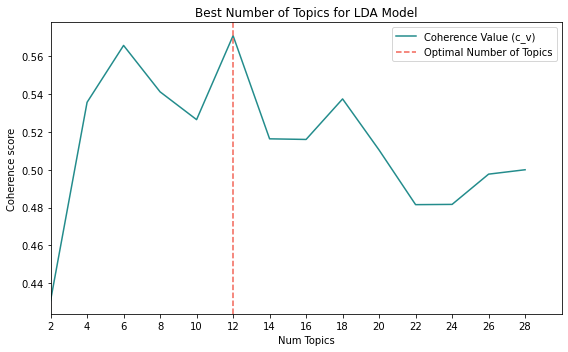

In [23]:
# Show graph
plt.figure(figsize=(8,5))

x = range(start, limit, step)
ax = sns.lineplot(x=x, y=coherence_values, color='#238C8C')

# Set titles and labels
plt.title("Best Number of Topics for LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xlim(start, limit)
plt.xticks(range(2, limit, step))

# Add a vertical line to show the optimum number of topics
plt.axvline(x[np.argmax(coherence_values)], color='#F26457', linestyle='--')

# Draw a custom legend
legend_elements = [Line2D([0], [0], color='#238C8C', ls='-', label='Coherence Value (c_v)'),
                   Line2D([0], [1], color='#F26457', ls='--', label='Optimal Number of Topics')]

ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig('topic_coherence.png', dpi=300)

## Train the Final Model and Visualize

In [24]:
NUM_TOPICS = 12
# Set training parameters.
chunksize = 2000
passes = 6
iterations = 100
eval_every = None
temp = dictionary[0]
id2word = dictionary.id2token

In [25]:
model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS,
    passes=passes,
    eval_every=eval_every
)

In [26]:
top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / NUM_TOPICS
print('Average topic coherence: %.4f.' % avg_topic_coherence)

pprint(top_topics)

Average topic coherence: -3.1195.
[([(0.039448995, 'car'),
   (0.036841486, 'tesla'),
   (0.023315277, 'model'),
   (0.017097224, 'make'),
   (0.01238486, 'year'),
   (0.011089275, 'new'),
   (0.009037831, 'buy'),
   (0.008652098, 'people'),
   (0.008580961, 'need'),
   (0.008146643, 'want'),
   (0.007538626, 'really'),
   (0.007480597, 'even'),
   (0.007172206, 'also'),
   (0.0071152863, 'come'),
   (0.0069772345, 'thing'),
   (0.0067581716, 'first'),
   (0.006439691, 'post'),
   (0.0064219446, 'much'),
   (0.006268771, 'sure'),
   (0.006264018, 'take')],
  -2.224762925412964),
 ([(0.027026888, 'lane'),
   (0.023645729, 'speed'),
   (0.022001814, 'drive'),
   (0.020780915, 'brake'),
   (0.01867445, 'car'),
   (0.018612951, 'stop'),
   (0.018410662, 'light'),
   (0.018208345, 'autopilot'),
   (0.017618973, 'road'),
   (0.01547923, 'turn'),
   (0.014834003, 'ap'),
   (0.012825663, 'control'),
   (0.010914118, 'driver'),
   (0.010691264, 'traffic'),
   (0.0100221345, 'slow'),
   (0.00930

In [27]:
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(model, corpus, dictionary, sort_topics=True)

pyLDAvis.display(lda_viz)


/Users/brianroepke/miniforge3/envs/NLP/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/brianroepke/miniforge3/envs/NLP/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/brianroepke/miniforge3/envs/NLP/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/brianroepke/miniforge3/envs/NLP/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/brianroepke/miniforge

In [28]:
pyLDAvis.save_html(lda_viz, 'lda.html')

In [29]:
pyLDAvis.disable_notebook()